In [380]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [381]:
con = duckdb.connect(database=':memory:')

df = pd.read_csv('APAC_Data_Analytics_Data.csv')
df.creationdate = pd.to_datetime(df.creationdate, dayfirst=True)
df.to_csv('APAC_DA_cleaned.csv')

In [382]:
df_apac = con.execute('''
    SELECT 
        bin::int as bin_number,
        case 
            when issuercountrycode = 'US'
            then 1 else 0 end :: int as is_US,
        count(*) over(
                partition by bin
                order by creationdate::date
                range between unbounded preceding
                        and current row)
                as count_bin_txns_ever,
        case 
            when genericresponse = 'FRAUD'
                and refused = 1 
            then 1 else 0 end :: int as fraud
    FROM 
        read_csv_auto('APAC_DA_cleaned.csv')
    WHERE
        creationdate >= '2017-10-01'
        and creationdate < '2017-10-07'
''').fetch_df()

In [383]:
# hyperparameters
fraud_size = df_apac.fraud.value_counts(normalize=True)[1]*100
class_weight={0: fraud_size, 1: 100}
number_of_nodes = list(range(3, 9))
tree_depth = list(range(1, 6))
features = list(range(1, len(df_apac.columns.tolist())))
param_grid = dict(max_leaf_nodes=number_of_nodes,
                  max_depth=tree_depth,
                  max_features=features)

In [384]:
X = df_apac.drop('fraud', axis=1).copy()
y = df_apac['fraud'].copy()

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [386]:
generic_clf_dt = DecisionTreeClassifier(random_state=0, class_weight=class_weight)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

In [387]:
grid = GridSearchCV(estimator=generic_clf_dt, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=cv, 
                    scoring='f1_weighted')

grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.895542 using {'max_depth': 4, 'max_features': 3, 'max_leaf_nodes': 8}
0.892098 (0.002884) with: {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 3}
0.892098 (0.002884) with: {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 4}
0.892098 (0.002884) with: {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 5}
0.892098 (0.002884) with: {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 6}
0.892098 (0.002884) with: {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 7}
0.892098 (0.002884) with: {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 8}
0.886490 (0.003518) with: {'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': 3}
0.886490 (0.003518) with: {'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': 4}
0.886490 (0.003518) with: {'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': 5}
0.886490 (0.003518) with: {'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': 6}
0.886490 (0.003518) with: {'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': 7}
0.886490 

In [388]:
best_max_leaf_nodes=grid_result.best_params_['max_leaf_nodes']
best_max_depth=grid_result.best_params_['max_depth']
best_max_features=grid_result.best_params_['max_features']

clf_dt = DecisionTreeClassifier(random_state=0,
                                class_weight=class_weight, 
                                max_leaf_nodes=best_max_leaf_nodes,
                                max_depth=best_max_depth,
                                max_features=best_max_features)

clf_dt = clf_dt.fit(X, y)

In [389]:
df_fi = pd.DataFrame(data={'feature_name': clf_dt.feature_names_in_.tolist(),
                           'importance': clf_dt.feature_importances_.tolist()})
df_fi.sort_values(by='importance',ascending=False)

,feature_name,importance
0,bin_number,0.867098
1,is_US,0.068542
2,count_bin_txns_ever,0.064361


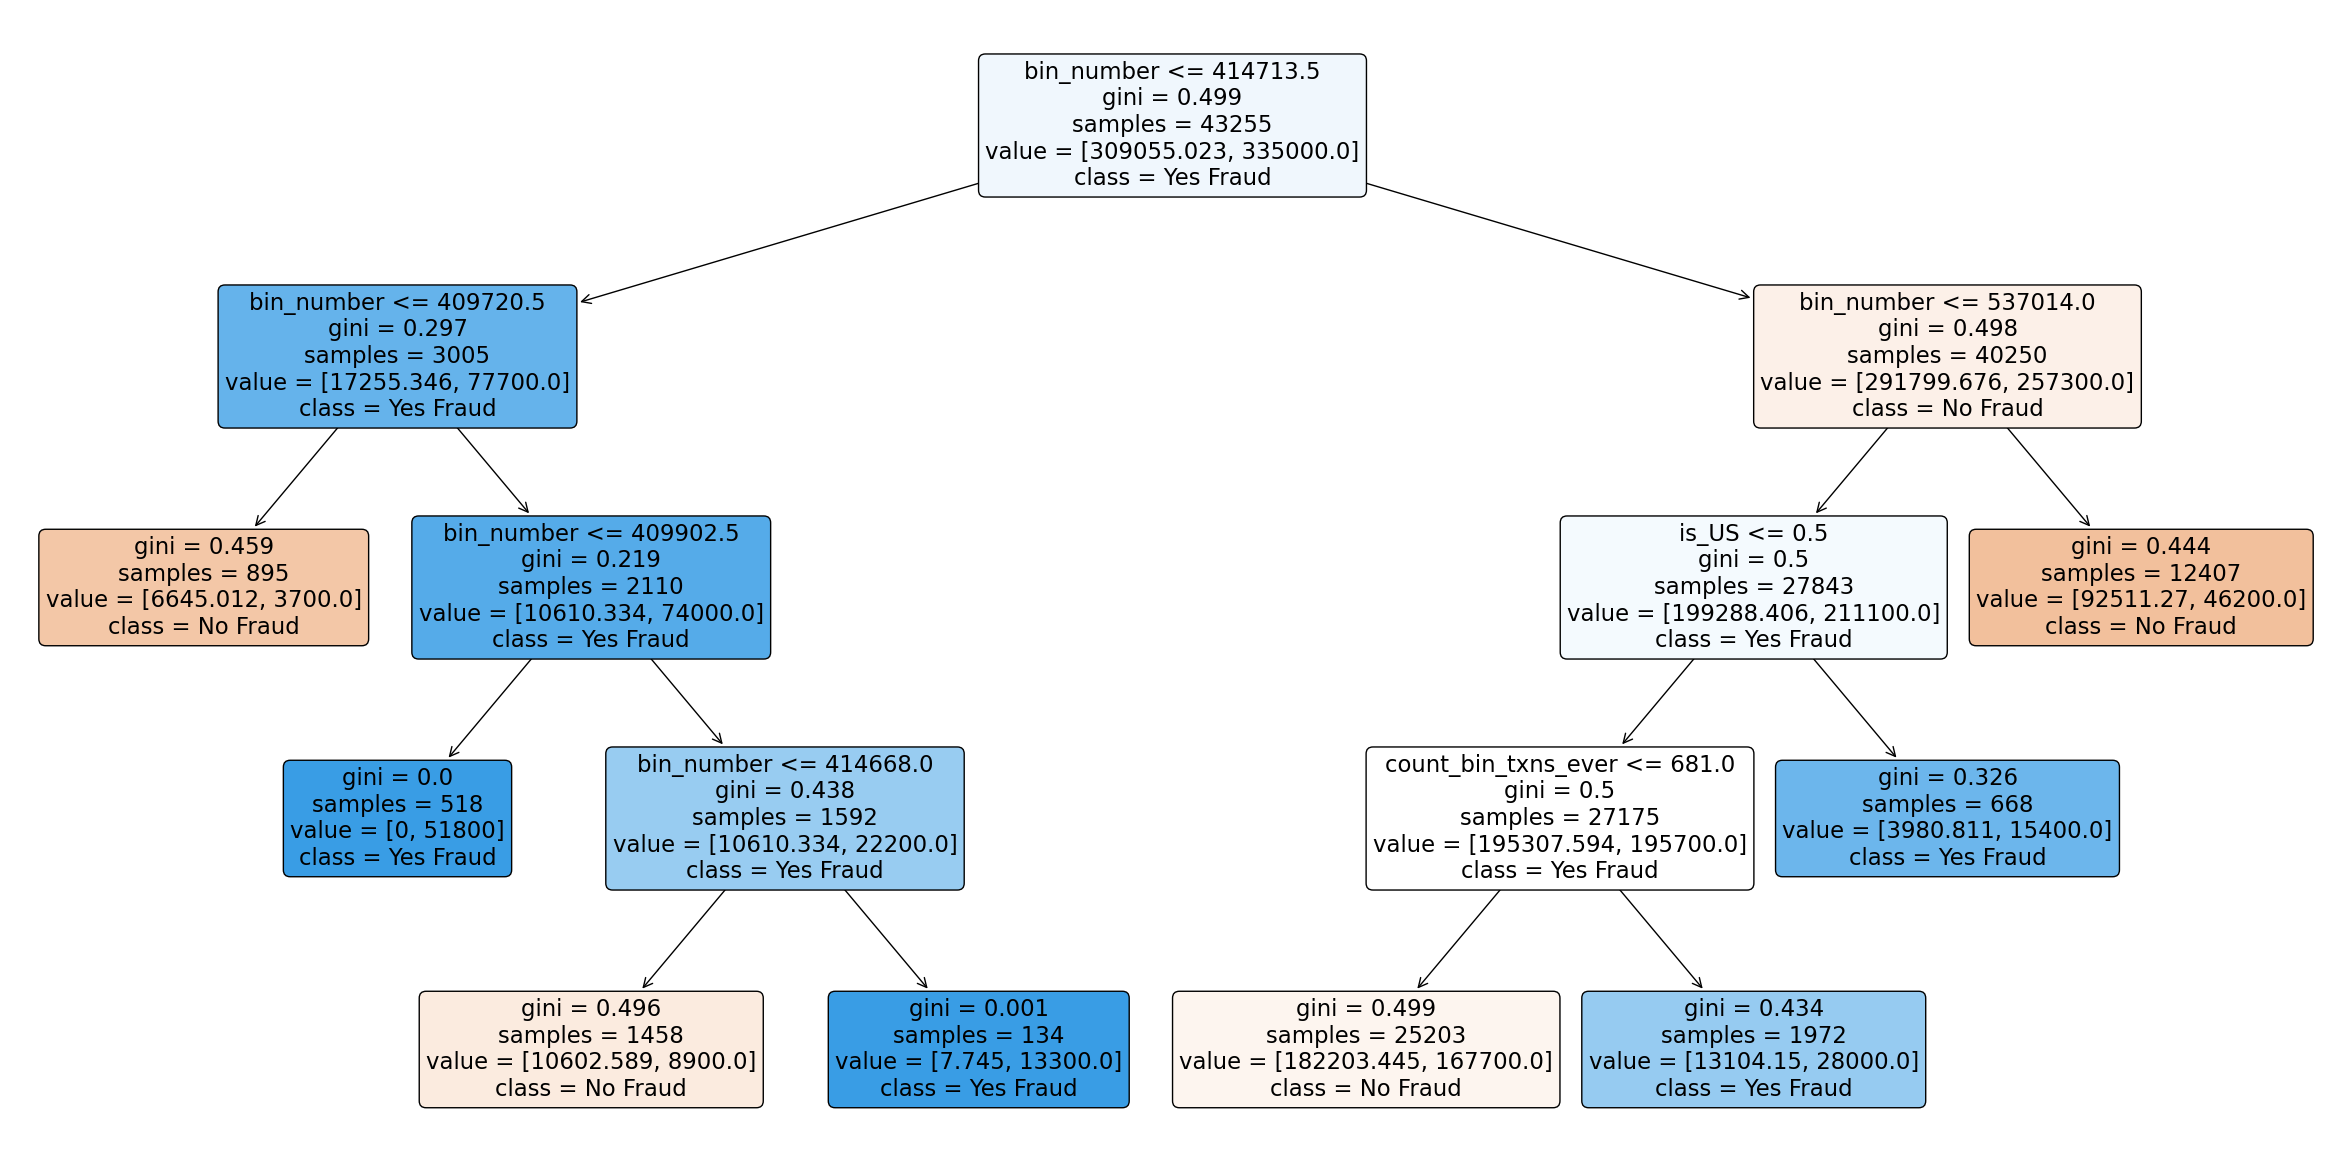

In [390]:
plt.figure(figsize=(30,15))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=['No Fraud', 'Yes Fraud'],
          feature_names=X.columns)

In [391]:
text_representation = tree.export_text(clf_dt, feature_names=X_train.columns.tolist())
print(text_representation)

|--- bin_number <= 414713.50
|   |--- bin_number <= 409720.50
|   |   |--- class: 0
|   |--- bin_number >  409720.50
|   |   |--- bin_number <= 409902.50
|   |   |   |--- class: 1
|   |   |--- bin_number >  409902.50
|   |   |   |--- bin_number <= 414668.00
|   |   |   |   |--- class: 0
|   |   |   |--- bin_number >  414668.00
|   |   |   |   |--- class: 1
|--- bin_number >  414713.50
|   |--- bin_number <= 537014.00
|   |   |--- is_US <= 0.50
|   |   |   |--- count_bin_txns_ever <= 681.00
|   |   |   |   |--- class: 0
|   |   |   |--- count_bin_txns_ever >  681.00
|   |   |   |   |--- class: 1
|   |   |--- is_US >  0.50
|   |   |   |--- class: 1
|   |--- bin_number >  537014.00
|   |   |--- class: 0



In [392]:
df_test = con.execute('''
    SELECT 
        bin::int as bin_number,
        case 
            when issuercountrycode = 'US'
            then 1 else 0 end :: int as is_US,
        count(*) over(
                partition by bin
                order by creationdate::date
                range between unbounded preceding
                        and current row)
                as count_bin_txns_ever,
        case 
            when genericresponse = 'FRAUD'
                and refused = 1 
            then 1 else 0 end :: int as fraud
    FROM 
        read_csv_auto('APAC_DA_cleaned.csv')
    WHERE
        creationdate >= '2017-10-07'
        and creationdate < '2017-10-09'
''').fetch_df()

In [393]:
X_test = df_test.drop('fraud', axis=1).copy()
y_test = df_test['fraud'].copy()

y_pred = clf_dt.predict(X_test)

In [394]:
print("Accuracy:    ",metrics.accuracy_score(y_test, y_pred))
print("F1-weighted: ",metrics.f1_score(y_test, y_pred, average='weighted'))
print("Recall:      ",metrics.recall_score(y_test, y_pred))
print("Precision:   ",metrics.precision_score(y_test, y_pred))

Accuracy:     0.934836913853401
F1-weighted:  0.9220086449782032
Recall:       0.25809617271835134
Precision:    0.6261904761904762


In [395]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

In [396]:
print(f'Approval Rate:  { ((tn / (tn + fp)) - 1) *100}')
print(f'CBK count:      { ((fn / (fn + tp)) - 1) *100}')
print(f'CBK rate:       { ((((fn / tn) *100)/((fn + tp) / (tn + fp) *100))-1)*100 }')

Approval Rate:  -1.2084359605911366
CBK count:      -25.80961727183513
CBK rate:       -24.90210733117898


In [397]:
con.execute('''
    WITH df AS (
        SELECT 
            *,
            count(*) over(
                partition by bin
                order by creationdate::date
                range between unbounded preceding
                        and current row)
                as count_bin_txns_ever
        FROM 
            read_csv_auto('APAC_DA_cleaned.csv')
    )
    , pattern AS (
        SELECT 
            case 
                when genericresponse not in ('APPROVED', 'FRAUD', 'DECLINED') 
                then 'OTHER' else genericresponse end as Status,
            count(*) as total,
            count(case 
                when (
                        bin::float >  414713.50
                        and bin::float <= 537014.00
                        and issuercountrycode = 'US'
                    ) or
                    (
                        bin::float >  414713.50
                        and bin::float <= 537014.00
                        and issuercountrycode != 'US'
                        and count_bin_txns_ever >  681.00
                    ) or
                    (
                        bin > 414668.00
                        and bin <= 414713.50
                    ) or
                    (
                        bin > 409720.50
                        and bin <= 409902.50
                    )
                then 1 end) as pattern
        FROM
            df
        GROUP BY 1
        ORDER BY 2 DESC
    )
    SELECT 
        Status,
        total,
        total::float / sum(total) over()::float as pct,
        pattern,
        pattern::float/total::float as pct_pattern,
        (total-pattern)/sum(total-pattern) over()::float as new_conversion,
        (((total-pattern)/sum(total-pattern) over()::float)
            / (total::float / sum(total) over()::float)-1)*100 as diff
    FROM
        pattern;
''').fetch_df()

,Status,total,pct,pattern,pct_pattern,new_conversion,diff
0,APPROVED,51670,0.888152,4337,0.083937,0.907127,2.136540
1,FRAUD,4369,0.075098,1561,0.357290,0.053815,-28.341019
2,DECLINED,1649,0.028345,80,0.048514,0.030070,6.085956
3,OTHER,488,0.008388,20,0.040984,0.008969,6.925583
4,NaN,1,0.000017,0,0.000000,0.000019,11.495042


In [398]:
avg_ticket = 9600.00
margin = 0.35
financial_loss = 4337 * (avg_ticket*margin)
cbk_avoided = 1561 * avg_ticket

print(cbk_avoided-financial_loss)

413280.0
